In [69]:
import tensorflow as tf
import matplotlib.pyplot as plt
from imu_dataset import IMUDataset
from model import IMUModelSmall
import numpy as np
from pathlib import Path
import random
import tensorflow.keras.callbacks as cb

# Parameters

In [70]:
VERSION = 'v2'
DATASET_PATH = "../dataset"
EXPORT_PATH = Path(f"model_{VERSION}")
TRAIN_VALID_SPLIT = 0.8
BATCH_SIZE = 32
EPOCHS = 800

In [71]:
def show_sample(sample, label):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(IMUDataset.IDX_TO_CLASS[label], fontsize=16)
    axs[0].set_title("Accelerometer")
    axs[0].plot(sample[:, 0], label="x")
    axs[0].plot(sample[:, 1], label="y")
    axs[0].plot(sample[:, 2], label="z")
    axs[0].legend()
    axs[1].set_title("Gyroscope")
    axs[1].plot(sample[:, 3], label="x")
    axs[1].plot(sample[:, 4], label="y")
    axs[1].plot(sample[:, 5], label="z")
    axs[1].legend()
    plt.show()

# Data preprocessing

In [72]:
dataset = IMUDataset(base_path=DATASET_PATH)

idxs = list(range(len(dataset)))

# set a good seed or
# in alternative, shuffle data so that it is balanced between classes
#random.seed(30)
#tf.random.set_seed(30)

random.shuffle(idxs)

split = int(len(dataset) * TRAIN_VALID_SPLIT)

idxs_train = idxs[:split]
idxs_valid = idxs[split:]

# split dataset into train and validation
train_data = np.stack([dataset[i][0] for i in idxs_train])
train_labels = np.stack([dataset[i][1] for i in idxs_train])

valid_data = np.stack([dataset[i][0] for i in idxs_valid])
valid_labels = np.stack([dataset[i][1] for i in idxs_valid])

train_data.shape, train_labels.shape, valid_data.shape, valid_labels.shape

((435, 300, 6), (435,), (109, 300, 6), (109,))

In [73]:
from collections import defaultdict

train = defaultdict(lambda: 0)
valid = defaultdict(lambda: 0)

for i in idxs_train:
    _, label = dataset[i]

    train[label] += 1

for i in idxs_valid:
    _, label = dataset[i]

    valid[label] += 1    

print("Train")
for k, v in train.items():
    print(f"{IMUDataset.IDX_TO_CLASS[k]}: {v}")

print("\nValid")
for k, v in valid.items():
    print(f"{IMUDataset.IDX_TO_CLASS[k]}: {v}")

Train
forehand: 119
backhand: 114
serve: 129
nothing: 73

Valid
nothing: 18
serve: 22
backhand: 37
forehand: 32


# Model

In [74]:
model = IMUModelSmall(*dataset.compute_means_stds())
model.build(input_shape=(None, 300, 6))
model.summary()

Model: "imu_model_small_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalize_4 (Normalize)     multiple                  0         
                                                                 
 conv1d_8 (Conv1D)           multiple                  152       
                                                                 
 dropout_12 (Dropout)        multiple                  0         
                                                                 
 conv1d_9 (Conv1D)           multiple                  100       
                                                                 
 dropout_13 (Dropout)        multiple                  0         
                                                                 
 max_pooling1d_4 (MaxPooling  multiple                 0         
 1D)                                                             
                                                 

In [75]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Training

In [76]:
history = model.fit(train_data, train_labels, epochs=EPOCHS, batch_size=32,
                    validation_data=(valid_data, valid_labels))

Epoch 1/800
14/14 [==============================] - 1s 31ms/step - loss: 2.4073 - accuracy: 0.2897 - val_loss: 1.1385 - val_accuracy: 0.4954
Epoch 2/800
14/14 [==============================] - 0s 12ms/step - loss: 1.7051 - accuracy: 0.3862 - val_loss: 1.0379 - val_accuracy: 0.5596
Epoch 3/800
14/14 [==============================] - 0s 11ms/step - loss: 1.4740 - accuracy: 0.4207 - val_loss: 0.9762 - val_accuracy: 0.6055
Epoch 4/800
14/14 [==============================] - 0s 9ms/step - loss: 1.2088 - accuracy: 0.4943 - val_loss: 0.9244 - val_accuracy: 0.6514
Epoch 5/800
14/14 [==============================] - 0s 9ms/step - loss: 1.0458 - accuracy: 0.5793 - val_loss: 0.8708 - val_accuracy: 0.6789
Epoch 6/800
14/14 [==============================] - 0s 9ms/step - loss: 0.9293 - accuracy: 0.6023 - val_loss: 0.8204 - val_accuracy: 0.7431
Epoch 7/800
14/14 [==============================] - 0s 13ms/step - loss: 0.7930 - accuracy: 0.6713 - val_loss: 0.7658 - val_accuracy: 0.7523
Epoch 8/8

In [77]:
loss, acc = model.evaluate(valid_data,  valid_labels, verbose=0)

print(f"Valid | Loss: {loss:.4f}, Acc: {acc*100:.1f}%")

Valid | Loss: 0.0686, Acc: 98.2%


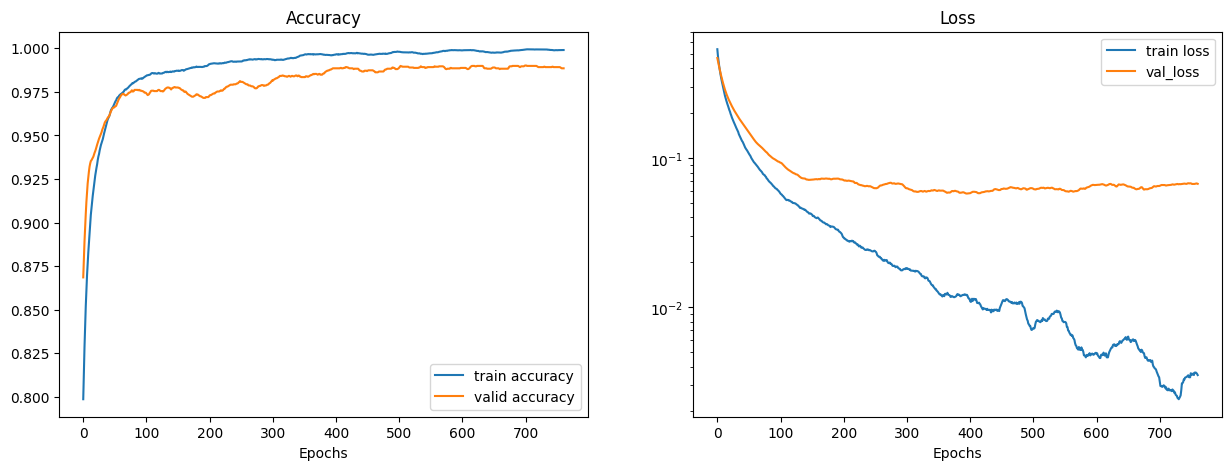

In [78]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# smoothing acc curve
acc = np.convolve(history.history['accuracy'], np.ones(40)/40, mode='valid')
val_acc = np.convolve(history.history['val_accuracy'], np.ones(40)/40, mode='valid')

axs[0].plot(acc, label='train accuracy')
axs[0].plot(val_acc, label = 'valid accuracy')
axs[0].set_title('Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].legend()

# smoothing loss curve
loss = np.convolve(history.history['loss'], np.ones(40)/40, mode='valid')
val_loss = np.convolve(history.history['val_loss'], np.ones(40)/40, mode='valid')

axs[1].semilogy(loss, label='train loss')
axs[1].semilogy(val_loss, label = 'val_loss')
axs[1].set_title('Loss')
axs[1].set_xlabel('Epochs')
axs[1].legend()

plt.show()

# Test inference

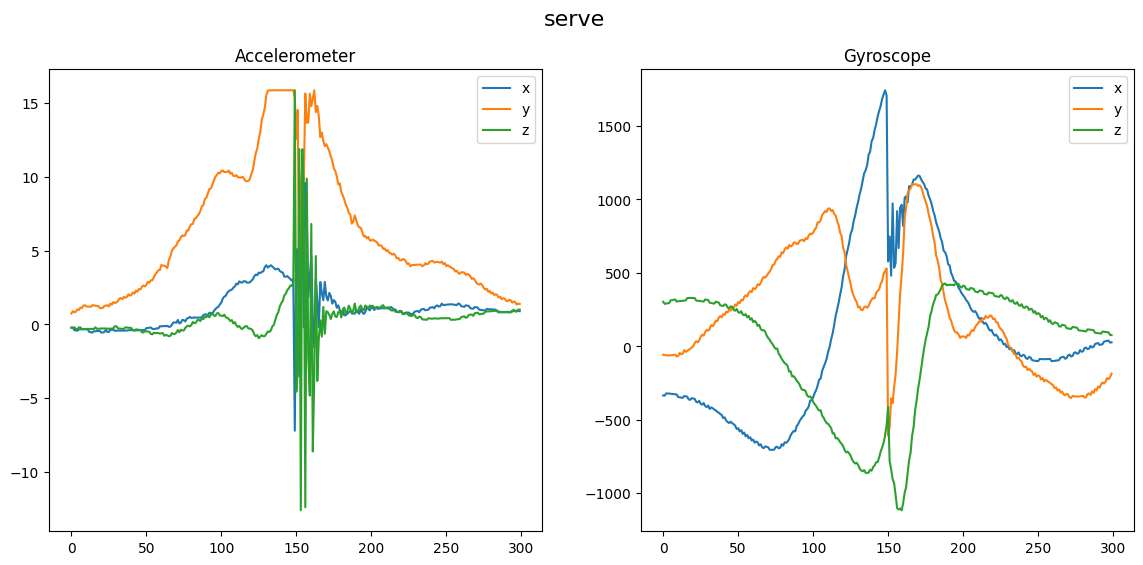

forehand: 0.00%
backhand: 0.00%
nothing: 0.00%
serve: 100.00%


In [79]:
#data, label = dataset[15]
data = valid_data[27]
label = valid_labels[27]
show_sample(data, label)

data = np.expand_dims(data, axis=0)

pred = model(data)
pred = pred.numpy() * 100
pred = pred[0].tolist()

for i, p in enumerate(pred):
    print(f"{IMUDataset.IDX_TO_CLASS[i]}: {p:.2f}%")

# Save model

In [80]:
tf.saved_model.save(model, EXPORT_PATH / f"model")

INFO:tensorflow:Assets written to: model_v2/model/assets


INFO:tensorflow:Assets written to: model_v2/model/assets


In [81]:
!python -m tf2onnx.convert --saved-model "{EXPORT_PATH}/model" --output "{EXPORT_PATH}/model.onnx"

/opt/anaconda3/envs/tensorflow/lib/python3.9/runpy.py:127: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
Metal device set to: Apple M2 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

2023-05-22 17:58:29,834 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2023-05-22 17:58:29,938 - INFO - Signatures found in model: [serving_default].
2023-05-22 17:58:29,938 - WARNING - '--signature_def' not specified, using first signature: serving_default
2023-05-22 17:58:29,938 - INFO - Output names: ['output_1']
2023-05-22 17:58:29,962 - INFO - Using tensorflow=2.12.0, onnx=1.14.0, tf2onnx=1.14.0/8f8d49
2023-05-22 17:58:29,962 - INFO - Using opset <onnx, 15>
2023-05-22 17:58:29,964 - INFO - Computed 0 values for constant folding
2023-05-22 17:58:29,972 - INFO - Optimizing ONNX model
2023-05-22 17:58:30,011 - INFO - Afte

# Quantization

In [82]:
def representative_dataset():
    for i in range(train_data.shape[0]):
        t = np.expand_dims(train_data[i], axis=0).astype(np.float32)
        yield [t]

In [83]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
#converter.inference_input_type = tf.int8
#converter.inference_output_type = tf.int8

quantized_model = converter.convert()
print("Bytes", len(quantized_model))
(EXPORT_PATH / f"model.tflite").write_bytes(quantized_model)

INFO:tensorflow:Assets written to: /var/folders/mk/xs0pl4dx2mv9kczxqtd16gk00000gn/T/tmp6lcf8qwd/assets


INFO:tensorflow:Assets written to: /var/folders/mk/xs0pl4dx2mv9kczxqtd16gk00000gn/T/tmp6lcf8qwd/assets


Bytes 8720


/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-05-22 17:58:30.870024: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-05-22 17:58:30.870039: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type: FLOAT32


8720

# Evaluate quantized model

In [84]:
interpreter = tf.lite.Interpreter(model_content=quantized_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

correct = 0
total = 0

loss_total = 0

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

for i in range(len(valid_data)):

    # Prepare the input data
    input_data = valid_data[i:i+1]
    input_data = input_data.astype(np.float32)

    # Run the inference
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # compute the loss
    loss = loss_fn(valid_labels[i], output_data).numpy()

    if loss > 0.1:
        print(f"High loss: {loss:.4f} for idx {i}")
        
    loss_total += loss


    # Compute the accuracy
    predicted_label = np.argmax(output_data)
    
    if predicted_label == valid_labels[i]:
        correct += 1
    total += 1

accuracy = correct / total 
loss = loss_total / total
print(f'Accuracy: {accuracy*100:.1f}%')
print(f"Loss: {loss:.4f}")

High loss: 0.5279 for idx 4
High loss: 16.1142 for idx 24
High loss: 0.2125 for idx 64
High loss: 0.2722 for idx 82
Accuracy: 99.1%
Loss: 0.1580


# Export to C array

In [85]:
!xxd -i "{EXPORT_PATH}/model.tflite" > "{EXPORT_PATH}/model.h"
!sed -i '' "s/model_{VERSION}_model_tflite/model/g" "{EXPORT_PATH}/model.h"